# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

In [1]:
# import usual libraries
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import numpy as np

import spacy
!python -m spacy download en_core_web_sm
import en_core_web_sm


display(f"Spacy version : {spacy.__version__}")
display(f"Tenserflow version : {tf.__version__}")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


'Spacy version : 2.2.4'

'Tenserflow version : 2.4.0'

### Import data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!mkdir ~/.kaggle
!mv /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


1. Loading csv files from Kaggle

In [6]:
# Load file train.csv
!kaggle competitions download -p /content/Kaggle_twitter -c nlp-getting-started -f train.csv

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.8MB/s]


In [7]:
# Load file test.csv
!kaggle competitions download -p /content/Kaggle_twitter -c nlp-getting-started -f test.csv

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 60.8MB/s]


In [8]:
# Load a sample of submissions
!kaggle competitions download -p /content/Kaggle_twitter -c nlp-getting-started -f sample_submission.csv

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 20.3MB/s]


2. Read files, check datasets frame

In [9]:
# create file path
def create_path(path) :
  all_datasets = [dataset for dataset in list(path.glob('*'))]
  all_datasets = [str(dataset) for dataset in all_datasets]
  return all_datasets

path = pathlib.Path("/content/Kaggle_twitter")
datasets_path = create_path(path)
datasets_path


['/content/Kaggle_twitter/test.csv',
 '/content/Kaggle_twitter/train.csv',
 '/content/Kaggle_twitter/sample_submission.csv']

In [164]:
# Create the dataframe from the train.csv file
df_train = pd.read_csv('Kaggle_twitter/train.csv')

display(df_train.head())
display(df_train.shape)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)

In [11]:
df_train['location'].value_counts()

USA                          104
New York                      71
United States                 50
London                        45
Canada                        29
                            ... 
highlands&slands scotland      1
Ames, Iowa                     1
Philippines                    1
Orlando,FL  USA                1
Elsewhere, NZ                  1
Name: location, Length: 3341, dtype: int64

In [12]:
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

### Preprocessing

1. Check the null values

In [13]:
# Print null values
print(df_train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


2. Keep only the usefull columns 

In [15]:
# get the columns we are interested in and look at the shape
df_train = df_train[['text', 'target']]

display(df_train.head())
display(df_train.shape)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 2)

In [170]:
df_train['text'][np.random.randint(100)]

'#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http://t.co/Av2JSjfFtc  #EDM'

In [16]:
# check the target and distribution per class
df_train['target'].value_counts()/len(df_train)*100

0    57.034021
1    42.965979
Name: target, dtype: float64

## With Spacy

1. Clean our texts to prepare them for training

In [17]:
# Load spacy language
nlp = en_core_web_sm.load()

# import english stop word from spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [18]:
# Create function
def clean_lemma_text (text) : 
  """Function which clean our texts and lemmatized them"""
  text = "".join([c for c in text if c.isalnum() or c == " "])
  text = text.replace(" +", " ").lower().strip()
  
  text = nlp(text)
  lemma = " ".join([token.lemma_ for token in text
                    if token.lemma_ not in STOP_WORDS
                    and token.lemma_ != '-PRON-'])
  return lemma

# apply the function on our text and add clean texts in our dataframe
df_train_spacy = df_train.copy()
df_train_spacy['clean_text'] = df_train_spacy['text'].apply(lambda x : clean_lemma_text (x))
df_train_spacy.head()


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school


In [19]:
# check if there is some clean texts which are empty
empty_reviews = df_train_spacy[(df_train_spacy['clean_text'] == " ") | 
                         (df_train_spacy['clean_text'] == "")]
display(len(empty_reviews))

0

### Tokenize

1. Encoding texts and padding texts

In [20]:
# Create a tokenizer instance
tokenizer = tf.keras.preprocessing.text.Tokenizer()

# Fit tokenizer on our texts
tokenizer.fit_on_texts(df_train_spacy['clean_text'])

# Encoding texts tokenized and store the result in our dataframe
df_train_spacy['text_encoded'] = tokenizer.texts_to_sequences(df_train_spacy['clean_text'])
df_train_spacy.head()

,text,target,clean_text,text_encoded
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[3682, 410, 168, 1367, 1944]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[113, 2, 157, 504, 5571, 5572, 954]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[1368, 442, 1691, 318, 5573, 289, 183, 1691, 3..."
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...,"[2313, 6, 2314, 68, 183, 290, 34]"
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school,"[176, 118, 5574, 1692, 169, 68, 2315, 105]"


In [21]:
# Padding texts encoded
texts_pad = tf.keras.preprocessing.sequence.pad_sequences(
                                             df_train_spacy['text_encoded'],
                                             padding = "post")
display(texts_pad[0:5])
display(texts_pad.shape)

array([[3682,  410,  168, 1367, 1944,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 113,    2,  157,  504, 5571, 5572,  954,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [1368,  442, 1691,  318, 5573,  289,  183, 1691,  318,  290,  376,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [2313,    6, 2314,   68,  183,  290,   34,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 176,  118, 5574, 1692,  169,   68, 2315,  105,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int32)

(7613, 25)

2. Create the tensor dataset from our texts padded and our target

In [22]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(texts_pad,
                                                    #df_train_spacy['target'],
                                                    #stratify = df_train_spacy['target'])

# Create the tensor dataset
#tf_data_test = tf.data.Dataset.from_tensor_slices((X_test,
                                                    #y_test)).batch(BATCH_SIZE)

#text_train, target_train = next(iter(tf_data_train))
#print(text_train, "\n", target_train)
#print()

#text_test, target_test = next(iter(tf_data_test))
#print(text_test, "\n\n", target_test)



In [23]:
# Create the tensor dataset
tf_data = tf.data.Dataset.from_tensor_slices((texts_pad,
                                              df_train_spacy['target'].values))

# Read the first tensor
text, target = next(iter(tf_data))
print(text, "\n\n", target)

tf.Tensor(
[3682  410  168 1367 1944    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int32) 

 tf.Tensor(1, shape=(), dtype=int64)


3. Spliting our tensor dataset in train and test set (75% in the train)

In [32]:
# Train test split with take and skip

TAKE_SIZE = int(0.70 * df_train_spacy.shape[0])
BATCH_SIZE = 16

train_data = tf_data.take(TAKE_SIZE)
test_data = tf_data.skip(TAKE_SIZE)

train_data = train_data.shuffle(len(train_data)).batch(BATCH_SIZE)
test_data = test_data.shuffle(len(test_data)).batch(BATCH_SIZE)

# Print a batch of data
text, target = next(iter(train_data))
print(text, "\n\n", target)

tf.Tensor(
[[ 6578   495    69  2013     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 1015     7   142    45  1606   274   395     5   773   119   128   120
   1473 12816     0     0     0     0     0     0     0     0     0     0
      0]
 [ 5020    13   163   655  3412   156     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 2701    31    17 14093 14094   345 14095  5064   150   205   677     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [ 6913   782  2047   282  3972  2441   354  6914  2048  6915  6916   634
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  134  1667  4567  3598  1413   180  1812   134 15681     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    5  2251  1323   988  1363  2252   638  22

### Modeling

In [33]:
# Vocabulary size
vocab_size = len(tokenizer.word_index)
vocab_size

20503

In [171]:
# Create our model
model_spacy = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size +1, 64, 
                                            input_shape=[text.shape[1],]),
                  #tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L2(0.001),
                                        #activation='relu',
                                        #input_shape=(vocab_size,)),
                  # Couche CNN
                  tf.keras.layers.Conv1D(16, 3, activation="relu"),  

                  # flatten output
                  tf.keras.layers.Flatten(),       

                  # Couche Dense classique 
                  tf.keras.layers.Dense(64,
                                        #kernel_regularizer = tf.keras.regularizers.L1(0.001), 
                                        activation='relu'),
                  tf.keras.layers.Dropout(0.04),

                  tf.keras.layers.Dense(32, activation='relu'),
                  #tf.keras.layers.Dense(16, activation='relu'),

                  tf.keras.layers.Dropout(0.04),

                  tf.keras.layers.Dense(16, activation='relu'),

                  #tf.keras.layers.Dropout(0.04),

                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
                                              
])

In [172]:
model_spacy.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 25, 64)            1312256   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 23, 16)            3088      
_________________________________________________________________
flatten_13 (Flatten)         (None, 368)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                23616     
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)              

In [173]:
initial_learning_rate = 0.0003

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True)

In [174]:
model_spacy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                    #loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    #metrics = [tf.keras.metrics.CategoricalAccuracy()])
                    loss = tf.keras.losses.binary_crossentropy,
                    metrics = [tf.keras.metrics.binary_accuracy])

In [175]:
history_spacy = model_spacy.fit(train_data,
                                validation_data = test_data,
                                epochs = 10)

Epoch 1/10
334/334 [==============================] - 5s 13ms/step - loss: 0.6836 - binary_accuracy: 0.5660 - val_loss: 0.6322 - val_binary_accuracy: 0.6729
Epoch 2/10
334/334 [==============================] - 4s 13ms/step - loss: 0.4861 - binary_accuracy: 0.7956 - val_loss: 0.5239 - val_binary_accuracy: 0.7377
Epoch 3/10
334/334 [==============================] - 4s 13ms/step - loss: 0.2285 - binary_accuracy: 0.9238 - val_loss: 0.5765 - val_binary_accuracy: 0.7452
Epoch 4/10
334/334 [==============================] - 4s 13ms/step - loss: 0.1040 - binary_accuracy: 0.9683 - val_loss: 0.7320 - val_binary_accuracy: 0.7005
Epoch 5/10
334/334 [==============================] - 4s 13ms/step - loss: 0.0497 - binary_accuracy: 0.9864 - val_loss: 0.8143 - val_binary_accuracy: 0.6891
Epoch 6/10
334/334 [==============================] - 4s 13ms/step - loss: 0.0540 - binary_accuracy: 0.9869 - val_loss: 0.8178 - val_binary_accuracy: 0.7045
Epoch 7/10
334/334 [==============================] - 4s 1

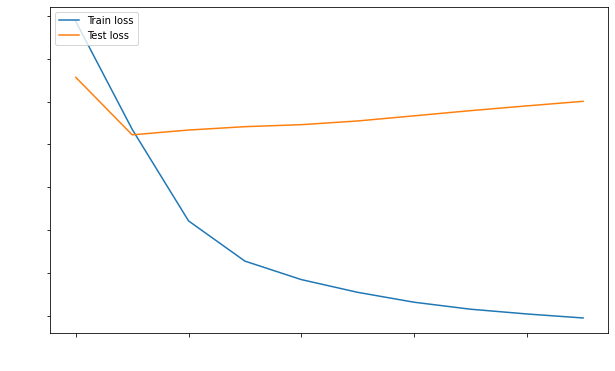

In [212]:
plt.figure(figsize=(10, 6))
plt.plot(history_spacy.history["loss"], label = 'Train loss')
plt.plot(history_spacy.history["val_loss"], label = 'Test loss')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(loc="upper left")

plt.ylabel("Loss", color = 'white')
plt.xlabel("Epochs", color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.show()

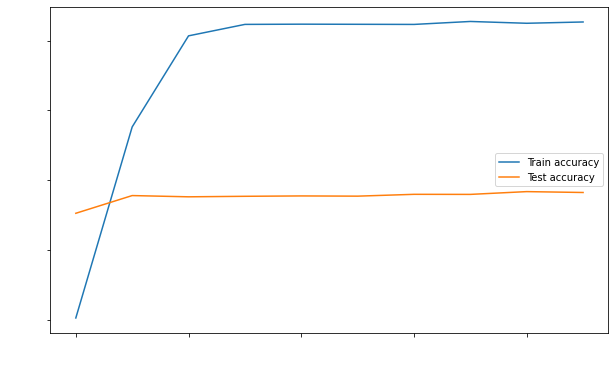

In [213]:
plt.figure(figsize=(10, 6))
plt.plot(history_spacy.history["binary_accuracy"],
         label = 'Train accuracy')
plt.plot(history_spacy.history["val_binary_accuracy"],
         label = 'Test accuracy')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(loc="center right")

plt.ylabel("Accuracy", color = 'white')
plt.xlabel("Epochs", color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.show()

### Without Spacy

In [165]:
# Create a tokenizer instance
#tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None, filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')

# Fit tokenizer on our texts
tokenizer.fit_on_texts(df_train['text'])

# Encoding texts tokenized and store the result in our dataframe
df_train['text_encoded'] = tokenizer.texts_to_sequences(df_train['text'])
df_train.head()

,id,keyword,location,text,target,text_encoded
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[508, 5474, 23, 1, 2628, 5, 24, 566, 868, 8700..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[430, 55, 214, 1368, 8702, 8703, 2629]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[204, 3161, 1633, 3, 8704, 4, 8705, 23, 140, 8..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[8708, 59, 5475, 1634, 348, 1369, 4, 94]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[225, 81, 1252, 24, 1253, 19, 8709, 3163, 28, ..."


In [62]:
# Padding texts encoded
texts_pad = tf.keras.preprocessing.sequence.pad_sequences(
                                             df_train['text_encoded'],
                                             padding = "post")
display(texts_pad[0:5])
display(texts_pad.shape)

array([[ 119, 4633,   24,    4,  868,    8,   21,  263,  138, 1619, 4634,
          89,   40,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 189,   45,  229,  799, 6954, 6955, 1404,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  40, 1751, 1620,    7, 6956,    6, 6957,   24,  136, 6958,   20,
        1752,   39,  441,  256,   57, 2158,    6,  714, 1405,   24, 1106,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 835, 2921,   59, 4635, 1500,  256, 1405,    6,   96,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  34,  100, 1221,   21,  320,   22, 6959, 2159,   30,  271,   22,
        1500, 6960,   69,    5,  1

(7613, 33)

2. Create the tensor dataset from our texts padded and our target

In [63]:
# Create the tensor dataset
tf_data = tf.data.Dataset.from_tensor_slices((texts_pad,
                                              df_train['target'].values))

# Read the first tensor
text, target = next(iter(tf_data))
print(text, "\n\n", target)

tf.Tensor(
[ 119 4633   24    4  868    8   21  263  138 1619 4634   89   40    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(33,), dtype=int32) 

 tf.Tensor(1, shape=(), dtype=int64)


3. Spliting our tensor dataset in train and test set (75% in the train)

In [64]:
# Train test split with take and skip
TAKE_SIZE = int(0.75 * df_train.shape[0])
BATCH_SIZE = 16

train_data = tf_data.take(TAKE_SIZE)
test_data = tf_data.skip(TAKE_SIZE)

train_data = train_data.shuffle(len(train_data)).batch(BATCH_SIZE)
test_data = test_data.shuffle(len(test_data)).batch(BATCH_SIZE)

# Print a batch of data
text, target = next(iter(train_data))
print(text, "\n\n", target)

tf.Tensor(
[[  159     4  9984  9985    65  3993   302  9986     5   547   432    13
   1456  1869   852   455    73     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [    5    52   970   765    55    20 12186    23     1     2 12187    13
   2113     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [ 1393  1038  1908    45   260   136   596     6  1393   191     8    75
   1709     6 14984 14985     3     1     2 14986     0     0     0     0
      0     0     0     0     0     0     0     0     0]
 [ 1249   276  4536  2133    19     4   216   935     5   276  1271    74
   6495     5  6496  3770  2860     3     1     2 17101     0     0     0
      0     0     0     0     0     0     0     0     0]
 [14209    51    10    27     7   126  1874    15  6132  4387   267    34
    515     0     0     0     0     0     0     0     0     0     0     0
      0     0     0  

### Modeling

In [65]:
# Vocabulary size
vocab_size = len(tokenizer.word_index)
vocab_size

22700

In [66]:
# Create our model
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size +1, 128,
                                            input_shape=[text.shape[1],]),

                  # Couche CNN
                  tf.keras.layers.Conv1D(16, 3, activation="relu"),  

                  # flatten output
                  tf.keras.layers.Flatten(),       

                  # Couche Dense classique 
                  tf.keras.layers.Dense(128, activation='relu'),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),

                  tf.keras.layers.Dropout(0.10),

                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid")
                                              
])

In [67]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 33, 128)           2905728   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 31, 16)            6160      
_________________________________________________________________
flatten_3 (Flatten)          (None, 496)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               63616     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

In [68]:
initial_learning_rate = 0.003

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.95,
    staircase=True)

In [69]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])

In [70]:
history = model.fit(train_data,
                    validation_data = test_data,
                    epochs = 20)

Epoch 1/20
357/357 [==============================] - 11s 28ms/step - loss: 0.6339 - binary_accuracy: 0.6316 - val_loss: 0.4718 - val_binary_accuracy: 0.7836
Epoch 2/20
357/357 [==============================] - 9s 26ms/step - loss: 0.2856 - binary_accuracy: 0.8895 - val_loss: 0.5567 - val_binary_accuracy: 0.7264
Epoch 3/20
357/357 [==============================] - 9s 26ms/step - loss: 0.0656 - binary_accuracy: 0.9786 - val_loss: 0.6973 - val_binary_accuracy: 0.7211
Epoch 4/20
357/357 [==============================] - 10s 27ms/step - loss: 0.0423 - binary_accuracy: 0.9860 - val_loss: 0.9152 - val_binary_accuracy: 0.6859
Epoch 5/20
357/357 [==============================] - 9s 26ms/step - loss: 0.0209 - binary_accuracy: 0.9938 - val_loss: 1.1766 - val_binary_accuracy: 0.6817
Epoch 6/20
357/357 [==============================] - 10s 27ms/step - loss: 0.0146 - binary_accuracy: 0.9926 - val_loss: 1.5243 - val_binary_accuracy: 0.7017
Epoch 7/20
357/357 [==============================] - 9

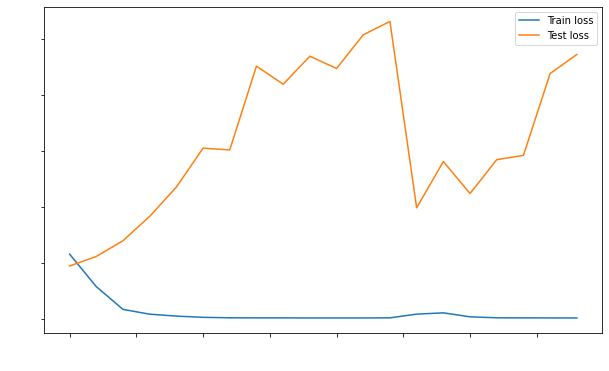

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label = 'Train loss')
plt.plot(history.history["val_loss"], label = 'Test loss')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(loc="upper right")

plt.ylabel("Loss", color = 'white')
plt.xlabel("Epochs", color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.show()

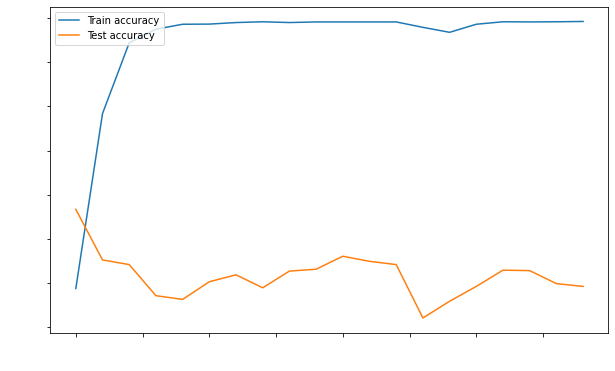

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["binary_accuracy"],
         label = 'Train accuracy')
plt.plot(history.history["val_binary_accuracy"],
         label = 'Test accuracy')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(loc="upper left")

plt.ylabel("Accuracy", color = 'white')
plt.xlabel("Epochs", color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.show()

### Recurent Neural Network (RNN)

In [149]:
texts_pad.shape[1]

25

In [187]:
model_rnn = tf.keras.Sequential([
           # Embedding layer
           tf.keras.layers.Embedding(vocab_size +1, 64,
                                     input_shape = [text.shape[1],]),
           
           # Bidirectional LSTM layer
           #tf.keras.layers.Bidirectional(
           tf.keras.layers.LSTM(64, return_sequences=True),

           # Bidirectional LSTM new layer
           #tf.keras.layers.Bidirectional(
           #tf.keras.layers.LSTM(64, return_sequences=False),
           
           # RepeatVector layer
           #tf.keras.layers.RepeatVector(texts_pad.shape[1]),
           
           # LSTM new layer
           tf.keras.layers.LSTM(32, return_sequences=True),

           # TimeDistributed layer
           #tf.keras.layers.TimeDistributed(
           tf.keras.layers.Dense(1, activation="sigmoid")
])

In [188]:
initial_learning_rate = 0.003

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.95,
    staircase=True)

In [189]:
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.binary_crossentropy,
              metrics = [tf.keras.metrics.binary_accuracy])

In [190]:
history_rnn = model_rnn.fit(train_data,
                    validation_data = test_data,
                    epochs = 20)

Epoch 1/20
334/334 [==============================] - 9s 19ms/step - loss: 0.5976 - binary_accuracy: 0.6727 - val_loss: 0.5325 - val_binary_accuracy: 0.7398
Epoch 2/20
334/334 [==============================] - 6s 17ms/step - loss: 0.2799 - binary_accuracy: 0.8899 - val_loss: 0.7143 - val_binary_accuracy: 0.6853
Epoch 3/20
334/334 [==============================] - 6s 17ms/step - loss: 0.1569 - binary_accuracy: 0.9476 - val_loss: 0.8916 - val_binary_accuracy: 0.6846
Epoch 4/20
160/334 [=============>................] - ETA: 2s - loss: 0.0875 - binary_accuracy: 0.9696

KeyboardInterrupt: ignored